Written by Zain Kamal [zain.eris.kamal@rutgers.edu](mailto:zain.eris.kamal@rutgers.edu) on 03/09/2024.

https://github.com/Humboldt-Penguin/redplanet

---
GOAL:

- I just found out xarray does the 

---
# [0] Setup

In [20]:
from redplanet import utils

from pathlib import Path
import matplotlib.pyplot as plt

import pooch
import numpy as np
import pandas as pd 
import xarray as xr

---
---
# [1] Download

In [2]:
with utils.disable_pooch_logger():
    fpaths_rawdat = pooch.retrieve(
        fname      = '2022_Mars_Odyssey_GRS_Element_Concentration_Maps.zip',
        url        = r'https://drive.google.com/file/d/1Z5Esv-Y4JAQvC84U-VataKJHIJ9OA4_8/view?usp=sharing',
        known_hash = 'sha256:45e047a645ae8d1bbd8e43062adab16a22786786ecb17d8e44bfc95f471ff9b7',
        path       = pooch.os_cache('redplanet') / 'GRS',
        downloader = utils.download_gdrive_file,
        processor  = pooch.Unzip(),
    )


fpaths_rawdat = [Path(f) for f in fpaths_rawdat if 'README_EBH_SK_AR_SK.txt' not in f]

another idea is to create a pooch object, but tbf it ends up being way more trouble than it's worth than to just download one by one:

    => **THIS WAY I'M NOT UNNECESSARILY HAVING TO WRITE MORE CLASSES/CODE THAT NEED TO BE MAINTAINED/MONITORED! SIMPLE IS BETTER :))))

---
---
# [2] Accessors (xarray and manual indexing)

---
## [2.1] xarray

In [3]:
dfs = []

for fpath_rawdat in fpaths_rawdat:
    element = fpath_rawdat.stem.split('_')[0].lower()

    df = pd.read_csv(
        fpath_rawdat, 
        sep='\s+', 
        na_values=9999.999, 
        header=0, 
        usecols=[0, 1, 2, 3], 
        names=['lat', 'lon', 'concentration', 'sigma']
    )

    if element == 'th':
        scale_factor = 0.000001     # correct given "ppm" to concentration out of 1
    else: 
        scale_factor = 0.01     # correct "weight percent" to concentration out of 1
    df[['concentration','sigma']] *= scale_factor

    df['element'] = element
    dfs.append(df)


all_dfs = pd.concat(dfs)

# add volatiles array for speed/convenience
volatiles_df = all_dfs[all_dfs['element'].isin(['cl', 'h2o', 's'])]
volatiles_sum = volatiles_df.groupby(['lat', 'lon']).sum(min_count=3).reset_index()
volatiles_sum['element'] = 'volatiles'
dfs.append(volatiles_sum)
all_dfs = pd.concat(dfs)




# dat_grs = xr.Dataset.from_dataframe(all_dfs.set_index(['lat', 'lon', 'element']))
# dat_grs = xr.Dataset.from_dataframe(all_dfs.set_index(['element', 'lon', 'lat']))
dat_grs = xr.Dataset.from_dataframe(all_dfs.set_index(['element', 'lat', 'lon']))


####################################################################################################################################


def grs_get1(element, lon, lat, quantity='concentration'):
    return dat_grs.sel(element=element).sel(lon=lon, lat=lat, method='nearest')[quantity].item()

In [4]:
dat_grs

<xarray.Dataset> Size: 416kB
Dimensions:        (element: 10, lat: 36, lon: 72)
Coordinates:
  * element        (element) object 80B 'al' 'ca' 'cl' ... 'si' 'th' 'volatiles'
  * lat            (lat) float64 288B -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * lon            (lon) float64 576B -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
Data variables:
    concentration  (element, lat, lon) float64 207kB nan nan nan ... nan nan nan
    sigma          (element, lat, lon) float64 207kB nan nan nan ... nan nan nan

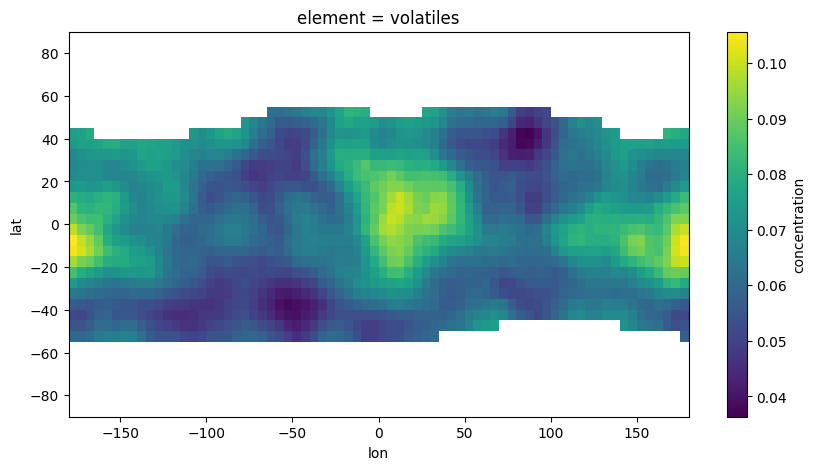

In [5]:
dat_grs.sel(element='volatiles').concentration.plot(figsize=(10,5))

---
## [2.2] manual indexing

In [6]:
lats = dat_grs.coords['lat'].values
lons = dat_grs.coords['lon'].values
elements = dat_grs.coords['element'].values.tolist()

dat_grs_dict = {}

dat_grs_dict['lats'] = lats
dat_grs_dict['lons'] = lons

for element in elements:
    dat_grs_dict[element] = {
        'concentration': dat_grs.sel(element=element).concentration.to_numpy(),
        'sigma':         dat_grs.sel(element=element).sigma.to_numpy(),
    }


####################################################################################################################################


# def grs_get2(element, lon, lat, quantity='concentration', epsilon=0):
#     # (purpose of epsilon:) when picking a coordinate exactly between two datapoints, numpy and xarray return different values. so we add this term to "bump" coordinates slightly so they're always equal :)
#     index_nearest_lat = np.argmin(np.abs(dat_grs_dict['lats'] - lat + epsilon))
#     index_nearest_lon = np.argmin(np.abs(dat_grs_dict['lons'] - lon + epsilon))
#     return dat_grs_dict[element][quantity][index_nearest_lat][index_nearest_lon] 



def grs_get2(element, lon, lat, quantity='concentration'):

    ### EXPLANATION -- The code below represents two ways of solving the problem: "given a value (lon/lat) and an array (lons/lats), find the index of the array element which is closest to the given value". The only difference is, in the case of a _tie_, the first method (commented out) chooses the lower index, and the second method chooses the higher index. We choose the latter because xarray's `sel` function with `method='nearest'` always chooses the higher index and we want consistent behavior here. 

    # index_nearest_lat = np.argmin(np.abs(dat_grs_dict['lats'] - lat + epsilon))
    # index_nearest_lon = np.argmin(np.abs(dat_grs_dict['lons'] - lon + epsilon))
    index_nearest_lat = dat_grs_dict['lats'].shape[0] - np.argmin(np.flip(np.abs(dat_grs_dict['lats'] - lat))) - 1
    index_nearest_lon = dat_grs_dict['lons'].shape[0] - np.argmin(np.flip(np.abs(dat_grs_dict['lons'] - lon))) - 1

    return dat_grs_dict[element][quantity][index_nearest_lat][index_nearest_lon] 

---
# [3] accessors give diff outputs???

In [7]:
# element = 'th'

# lons = np.arange(11, 12, 0.1)
# lats = np.arange(-15, -5, 0.1)
# lats = np.arange(5, 15, 0.1)

# lons = np.round(lons,2)
# lats = np.round(lats,2)

# lons = np.arange(-180, 180, 0.1)
# lats = np.arange(-90, 90, 0.1)


# coords = np.array([lons, lats]).T
# coords = np.array(np.meshgrid(lons, lats)).T.reshape(-1, 2) 

# print(f'num data points: {coords.shape[0]}')






# dat1 = []
# for coord in coords:
#     # dat1.append(grs_get1(element=element, lon=coord[0], lat=coord[1]))
#     dat1.append(grs_get1(element=element, lon=np.round(coord[0],2), lat=np.round(coord[1],2)))
# dat1 = np.array(dat1)



# dat2 = []
# for coord in coords:
#     # dat2.append(grs_get2(element=element, lon=coord[0], lat=coord[1]))
#     dat2.append(grs_get2(element=element, lon=coord[0], lat=coord[1], epsilon=-1e-10))
# dat2 = np.array(dat2)


In [8]:
# '''look for places where two methods produce different outputs'''

# diff_mask = ~np.equal(dat1,dat2)

# for i,val in enumerate(diff_mask):
#     if val:
#         print(f'{i = }')
#         print(f'\t{dat1[i] = }')
#         print(f'\t{dat2[i] = }')
#         print(f'\t{coords[i] = }')

In [9]:
# '''proper time benchmarking'''

# lons = np.round(lons,2)
# lats = np.round(lats,2)

# dat11 = dat_grs.sel(element=element).sel(lon=lons, lat=lats, method='nearest')['concentration'].values
# dat12 = np.array([[grs_get1(element=element, lon=lon, lat=lat) for lon in lons] for lat in lats])
# dat2 = np.array([[grs_get2(element=element, lon=lon, lat=lat, epsilon=-1e-3) for lon in lons] for lat in lats])

In [10]:
# print(np.array_equal(dat11,dat2))
# print(np.array_equal(dat12,dat2))

CONCLUSIONS for implementation:

1. first idea:
    - use manual numpy indexing with epsilon for SINGLE VALUES ONLY
        - we can do 10^5 accesses per second, anything less than that is unnoticeable
    - use xarray WITH ROUNDED INPUTS for SWATHS (just round based on precision of the requested spacing!!!)
        <!-- - 10^7 manual-indexing-accesses would take about 2 minutes, but with xarray it's less than 0.1 seconds :3 -->
        - Lets say we want to get values _for just one element_ over all of mars (-180->180, -90->90) with a 0.1 degree resolution (this is most relevant for calculations). That's 6480000 accesses. Manual indexing takes 1.5. But xarray takes <0.1 seconds :3
            - this is not even mentioning that usually for calculations we want multiple elements, so the difference is even more pronounced.
2. second idea:
    - (reasoning) — i was initially thinking that the individual indexing isn't needed at all (just use xarray indexing, and if that's ever getting too slow, then switch to swath indexing) -- but might as well still include it for any random edge-cases like accessing crust values in a circle or something idk. it's faster by 1-2 orders of magnitude so not trivial for sure.

### how to fix the bad rounding:

In [36]:
'''compare more'''


lon_bounds = (-180,360)
lat_bounds = (-90,90)
grid_spacing = 1

lons = np.arange(lon_bounds[0], lon_bounds[1], grid_spacing)
lats = np.arange(lat_bounds[0], lat_bounds[1], grid_spacing)


lons = np.round(lons, 10)
lats = np.round(lats, 10)

lons = utils.clon2lon(lons)


dat_xswath = dat_grs.sel(element=element).sel(lon=lons, lat=lats, method='nearest')['concentration'].values
# dat_xquery = np.array([[grs_get1(element=element, lon=lon, lat=lat) for lon in lons] for lat in lats]) # wastes time, always identical to xswath method
# dat_manual = np.array([[grs_get2(element=element, lon=lon, lat=lat, epsilon=-1e-3) for lon in lons] for lat in lats])
dat_manual = np.array([[grs_get2(element=element, lon=lon, lat=lat) for lon in lons] for lat in lats])

# np.allclose(dat_xswath, dat_manual)
np.array_equal(dat_xswath, dat_manual, equal_nan=True)

True

In [33]:
dat_xswath = dat_grs.sel(element=element).sel(lon=lons, lat=lats, method='nearest')['concentration'].values

In [32]:
dat_manual = np.array([[grs_get2(element=element, lon=lon, lat=lat) for lon in lons] for lat in lats])

In [35]:
# dat_xquery = np.array([[grs_get1(element=element, lon=lon, lat=lat) for lon in lons] for lat in lats]) # SO SLOW DAMN, i just manually stopped after a minute gyat damn

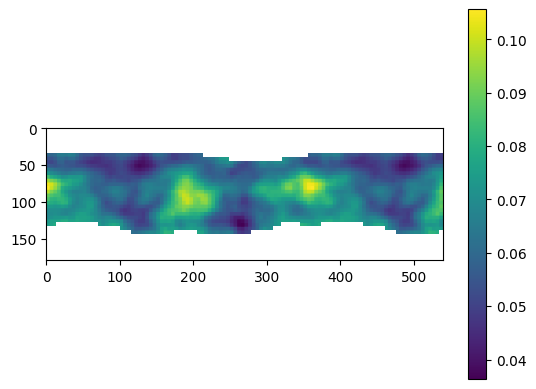

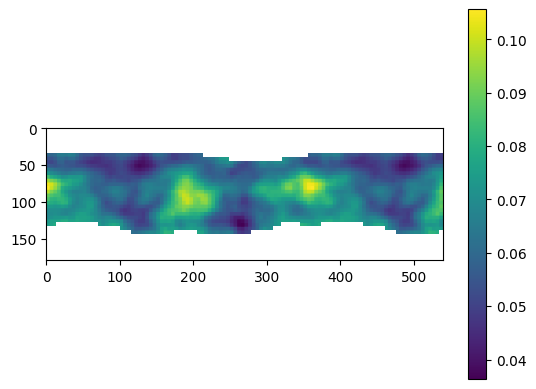

In [29]:
plt.imshow(dat_xswath)
plt.colorbar()
plt.show()
plt.imshow(dat_manual)
plt.colorbar()
plt.show()

In [ ]:
## try 1
# num_points = int((lon_bounds[1] - lon_bounds[0]) / (grid_spacing))

# np.linspace(lon_bounds[0], lon_bounds[1], num_points)

# end = lon_bounds[0] + num_points * grid_spacing
# np.linspace(lon_bounds[0], end, num_points)

In [ ]:
## try 2
# num_points = int((lon_bounds[1] - lon_bounds[0]) / (grid_spacing))
# [lon_bounds[0] + grid_spacing*i for i in range(num_points)]

In [ ]:
## try 3
# import math

# num_points = math.ceil((lon_bounds[1] - lon_bounds[0]) / grid_spacing)
# np.linspace(lon_bounds[0], lon_bounds[1] + (num_points-1) * grid_spacing, num_points)

In [ ]:
# np.allclose(dat_xswath, dat_manual)
# np.array_equal(dat_xswath, dat_manual)

True

In [ ]:
# np.any(~(-180 <= lons))

False

---
# [4] wraparound

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# '''old algorithm (not actually necessary! clon2lon is a catch-all)'''
# # if lons[0] < 180 < lons[-1]:
# if lons[-1] > 180:
#     idx = np.searchsorted(lons, 180)
#     lons_before_180 = lons[:idx]
#     lons_after_180 = utils.clon2lon(lons[idx:])
#     lons = np.concatenate([lons_before_180, lons_after_180])

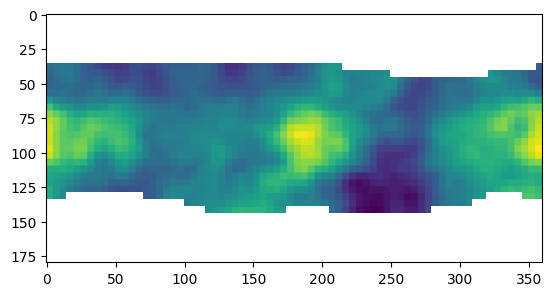

In [ ]:
lons = np.arange(-180,180,1)
lats = np.arange(-90,90,1)

lons = utils.clon2lon(lons)
# lons
dat = dat_grs.sel(element='s').sel(lon=lons, lat=lats, method='nearest')['concentration'].values
plt.imshow(dat)

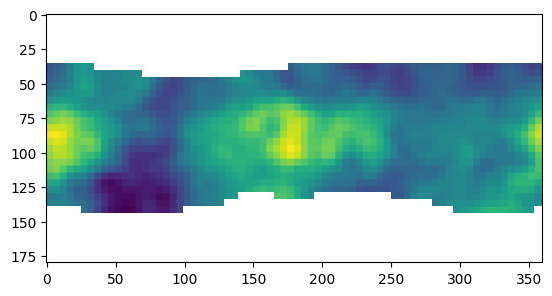

In [ ]:
lons = np.arange(0,360,1)
lats = np.arange(-90,90,1)

lons = utils.clon2lon(lons)
dat = dat_grs.sel(element='s').sel(lon=lons, lat=lats, method='nearest')['concentration'].values
plt.imshow(dat)